This is the notebook to run the GRU network. It starts with a preprocessed file with p2_calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

All data is in its original units.

Also, I'm running this in the Python 3.7.1 Kernel

In [8]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker

In [9]:
#load the data
train = pd.read_csv('../data/train.csv', index_col=0)
valid = pd.read_csv('../data/valid.csv', index_col=0)
test = pd.read_csv('../data/test.csv', index_col=0)

In [10]:
#number of lag variables and horizon (these are just some starting choices)
T = 4*24 #the past N hours to study
HORIZON = 1 #predict the next N hours

#sample tensor structure
tensor_structure = {'X':(range(-T+1, 1), ['p2_calib', 'int_deliv_inv_ub'])}

#training tensor
train_input = TimeSeriesTensor(
    dataset=train,
    target="p2_calib",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="H", #hours
    drop_incomplete=True, 
)

#validation tensor
valid_inputs = TimeSeriesTensor(valid, "p2_calib", HORIZON, tensor_structure)
print(train_input['X'][0])
print(train_input['target'][0])

print(valid_inputs['X'][0])
print(valid_inputs['target'][0])

NotImplementedError: This method is only implemented for DatetimeIndex, PeriodIndex and TimedeltaIndex; Got type Index

In [19]:
#now we bring in the keras tensorflow model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [20]:
LATENT_DIM = 50
BATCH_SIZE = 32
EPOCHS = 50

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [21]:
model.compile(optimizer="RMSprop", loss="mse")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8100      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,151
Trainable params: 8,151
Non-trainable params: 0
_________________________________________________________________


In [22]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [23]:
model_history = model.fit(
    train_input["X"],
    train_input["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/50
80/80 [==============================] - 6s 45ms/step - loss: 0.0968 - val_loss: 0.0097
Epoch 2/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0106 - val_loss: 0.0083
Epoch 3/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 4/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 5/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0096 - val_loss: 0.0079
Epoch 6/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 7/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 8/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 9/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 10/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 11/

dict_keys(['loss', 'val_loss'])


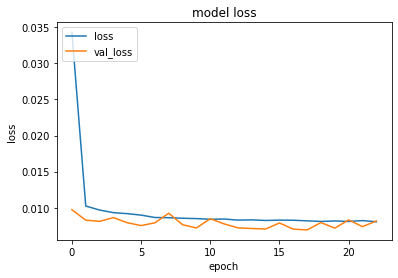

In [34]:
# list all data in history
print(model_history.history.keys())

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [35]:
#now we'll test
data_test_inputs = TimeSeriesTensor(test, "p2_calib", HORIZON, tensor_structure)
#print(data_test_inputs['X'][0])
#print(data_test_inputs['target'][0])

predictions = model.predict(data_test_inputs["X"])
#print(predictions)
ev_data = create_evaluation_df(predictions, data_test_inputs, HORIZON, y_scaler)
#print(ev_data.head())
test.head()

,p2_calib,int_deliv_inv_ub
2018-10-15 01:27:23,0.652546,0.666136
2018-10-15 02:27:23,0.584382,0.692726
2018-10-15 03:27:23,0.628083,0.000000
2018-10-15 04:27:23,0.654997,0.000000
2018-10-15 05:27:23,0.648064,0.000000


/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


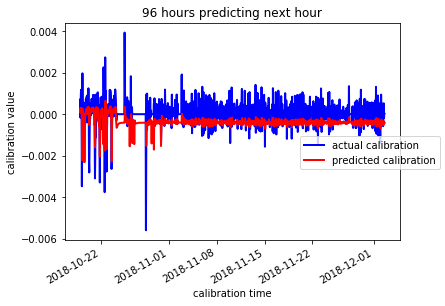

In [36]:
#lets plot our results
fig6, ax9 = plt.subplots()

ax9.set_title('{time:.0f} hours predicting next hour'.format(time=T))
ax9.set_ylabel('calibration value')
ax9.set_xlabel('calibration time')
plt.setp(ax9.get_xticklabels(), rotation=30, horizontalalignment='right')

ax9.plot(ev_data.timestamp, ev_data.actual, 
         label='actual calibration', color='blue', linewidth=2, linestyle='solid')

ax9.plot(ev_data.timestamp, ev_data.prediction, 
         label='predicted calibration', color='red', linewidth=2, linestyle='solid')
#legend
fig6.legend(ncol=1, loc = 'right')
fig6.show()

In [37]:
#now we'll look at zoomed in view
start = '2018-11-15 00:00:00'
stop = '2018-11-16 00:00:00'

ev_data_zoom = ev_data[( (ev_data.timestamp > start) & (ev_data.timestamp < stop) )]

ev_lumi_zoom = test_lumi_avg[( (test_lumi_avg.index > start) & (test_lumi_avg.index < stop) )]

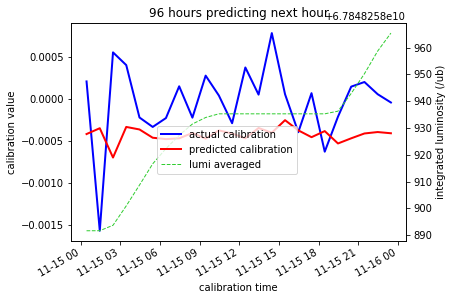

In [38]:
#lets plot our results
fig7, ax10 = plt.subplots()

ax10.set_title('{time:.0f} hours predicting next hour'.format(time=T))
ax10.set_ylabel('calibration value')
ax10.set_xlabel('calibration time')
plt.setp(ax10.get_xticklabels(), rotation=30, horizontalalignment='right')

ax10.plot(ev_data_zoom.timestamp, ev_data_zoom.actual, 
         label='actual calibration', color='blue', linewidth=2, linestyle='solid')

ax10.plot(ev_data_zoom.timestamp, ev_data_zoom.prediction, 
         label='predicted calibration', color='red', linewidth=2, linestyle='solid')

#lumi data on alternate y axis
ax11 = ax10.twinx()
ax11.set_ylabel('integrated luminosity (/ub)')

ax11.plot(ev_lumi_zoom.index, ev_lumi_zoom, 
         label='lumi averaged', color='limegreen', linewidth=1, linestyle='dashed')

#legend
fig7.legend(ncol=1, loc='center')
fig7.show()

In [39]:
mape(ev_data["prediction"], ev_data["actual"])

inf

In [40]:
#our data is transformed to feed into the model. The diff step transforms the data by removing the large scale trends. We'll run that in reverse to look at the data with the trends.
ev_data_int = ev_data.copy()
ev_data_int['prediction'] = ev_data_int['prediction'].cumsum()
ev_data_int['actual'] = ev_data_int['actual'].cumsum()
ev_data.head()

,timestamp,h,prediction,actual
0,2018-10-19 00:27:23,t+1,0.000118,0.000702
1,2018-10-19 01:27:23,t+1,0.000291,-0.000168
2,2018-10-19 02:27:23,t+1,0.000067,0.000753
3,2018-10-19 03:27:23,t+1,0.000292,0.001175
4,2018-10-19 04:27:23,t+1,0.000305,0.000855


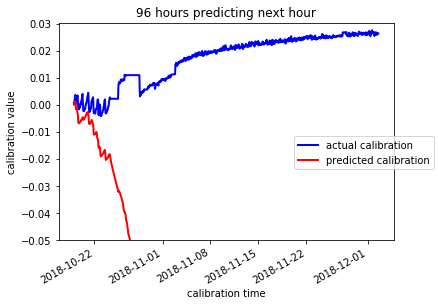

In [48]:
#lets plot our results
fig10, ax13 = plt.subplots()

ax13.set_title('{time:.0f} hours predicting next hour'.format(time=T))
ax13.set_ylabel('calibration value')
ax13.set_xlabel('calibration time')
plt.setp(ax13.get_xticklabels(), rotation=30, horizontalalignment='right')

ax13.plot(ev_data_int.timestamp, ev_data_int.actual, 
         label='actual calibration', color='blue', linewidth=2, linestyle='solid')

ax13.plot(ev_data_int.timestamp, ev_data_int.prediction, 
         label='predicted calibration', color='red', linewidth=2, linestyle='solid')

#lumi data on alternate y axis
#ax14 = ax13.twinx()
#ax14.set_ylabel('integrated luminosity (/ub)')
#
#ax14.plot(test_lumi_avg.index, test_lumi_avg, 
#         label='lumi averaged', color='limegreen', linewidth=1, linestyle='dashed')

#legend
fig10.legend(ncol=1, loc='right')
plt.ylim([-.05, ev_data_int.actual.max()*1.1])
fig10.show()